# Shawonの論文のコード

## 26x26のウエハに限定して機械学習させる

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join

import numpy as np
import pandas as pd

import sklearn


from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras

from keras import layers, Input, models
from keras.utils import to_categorical

Using TensorFlow backend.


['LSWMD.pkl']


### データについて

In [3]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- データセットは811,457枚のウエハマップから構成されている．

In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [5]:
df = df.drop(['waferIndex'], axis = 1)

In [6]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
254306,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4612.0,lot15731,[],[],"(81, 73)"
718192,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1256.0,lot43757,[[Test]],[[none]],"(41, 40)"
668888,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot41651,[],[],"(32, 29)"
538118,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot33591,[],[],"(32, 29)"
321713,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1361.0,lot19467,[],[],"(39, 45)"


- 不良パターンと学習orテストラベルを数値で表す．

In [7]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [8]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [9]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

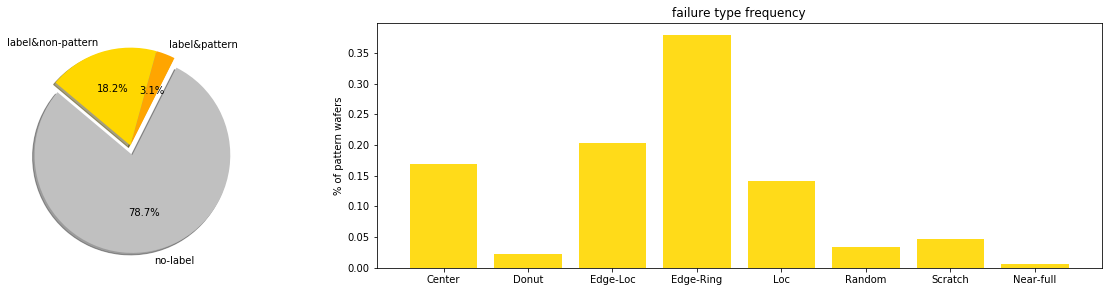

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

- 結果として，172,950枚のウエハは不良ラベルを持ち，78.7%のウエハは不良ラベルがない．
- また，ラベル付きのウエハのうち，実際に不良パターンがあるのは全体のわずか3.1%(25,519枚)であり，残りの147,431枚のウエハは不良パターンが`none`となっている．
- その結果，実際に不良パターンがあるのは3.1%(25,519枚）だけであり，計算量は大幅に削減される．
- 上の2つ目の図から，データセットは高い不均衡分布を示していることがわかる．

### 26x26のデータに対して処理

In [11]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [12]:
sub_df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0


In [13]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [14]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


- 26x26のウエハが14366枚抽出できた．

- それぞれの不良パターンを1枚ずつ可視化する

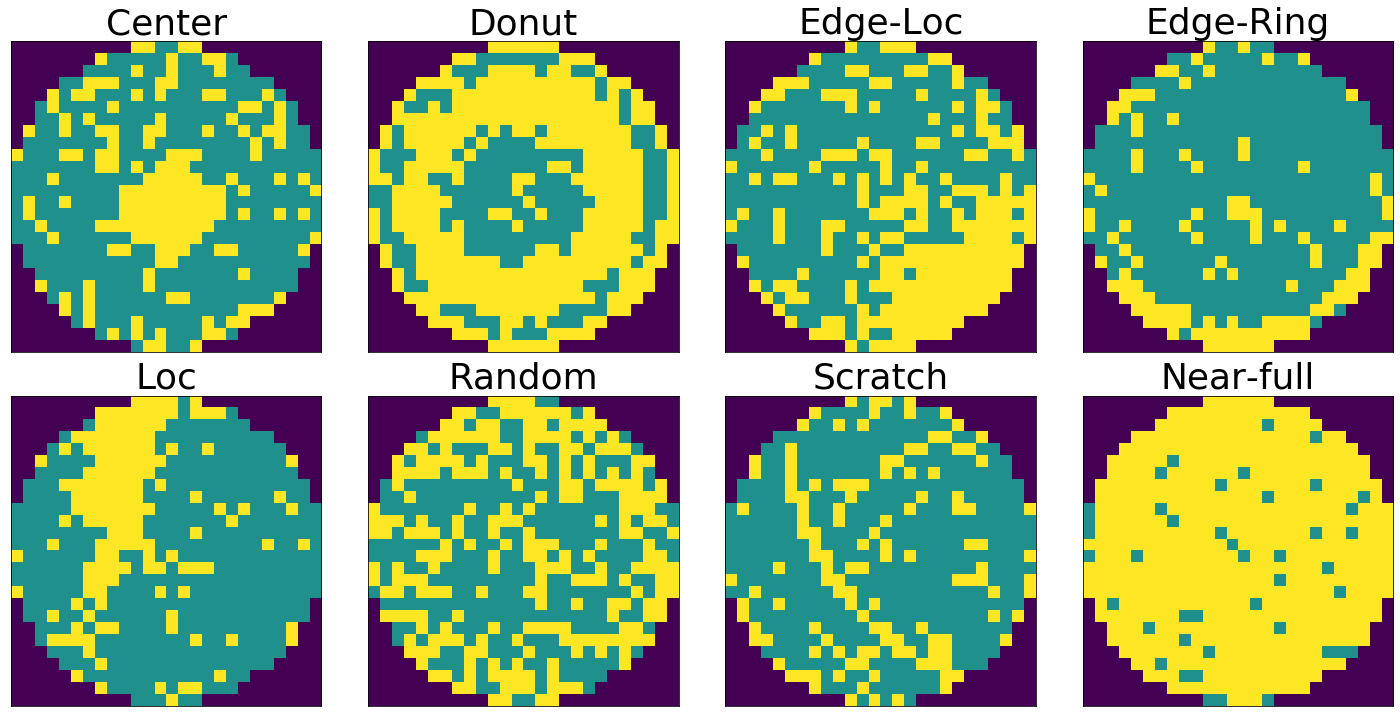

In [15]:
ind = [3224, 10686, 217, 4389, 1283, 395, 2497, 668]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = x[ind[i]]
    ax[i].imshow(img)
    ax[i].set_title(y[ind[i]][0],fontsize=36)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

- 最初のデータを可視化してみる．

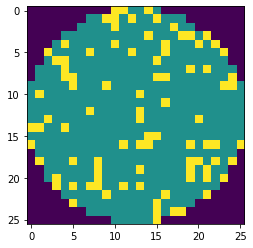

Faulty case : ['none'] 


In [16]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [17]:
x = x.reshape((-1, 26, 26, 1))
x.shape

(14366, 26, 26, 1)

In [18]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [19]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [20]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [21]:
new_x.shape

(14366, 26, 26, 3)

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．

### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [22]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [23]:
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [24]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [25]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
14366/14366 [==============================] - 5s 343us/step - loss: 0.1574
Epoch 2/30
14366/14366 [==============================] - 1s 44us/step - loss: 0.0978
Epoch 3/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0861
Epoch 4/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0749
Epoch 5/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0644
Epoch 6/30
14366/14366 [==============================] - 1s 44us/step - loss: 0.0566
Epoch 7/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0508
Epoch 8/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0457
Epoch 9/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0408
Epoch 10/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0360
Epoch 11/30
14366/14366 [==============================] - 1s 43us/step - loss: 0.0318
Epoch 12/30
14366/14366 [==========================

- エンコーダだけのモデルを定義する．

In [26]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [27]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [28]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [29]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

- 元のウエハ画像

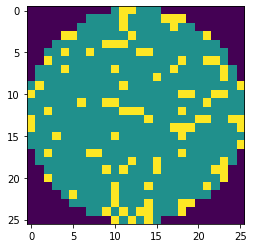

In [30]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

- ノイズが付加されたウエハ画像

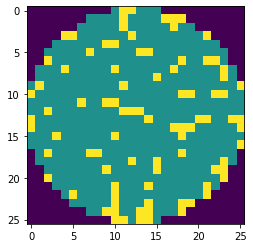

In [31]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．

In [32]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [33]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [34]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [35]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


- データオーギュメンテーションを行った結果，各不良データごとに2000枚増えた．
- 合計は30707枚となった．

- 不良ラベルのないデータは削除し，枚数を不良ラベルと同程度にする．

In [36]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [37]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [38]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [39]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


- 削除した結果，全体は19707枚となった．

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

In [40]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i

In [41]:
# one-hot-encoding
new_y = to_categorical(new_y)

- 学習データ（学習データと学習時のテストデータ）と最終的なテストデータに分割する．

In [42]:
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape

(705, 26, 26, 3)

In [43]:
print(new_X.dtype)
print(new_Y.dtype)

float64
float32


In [45]:
new_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

- 学習データを学習データと学習時のテストデータに分割する．

In [43]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [44]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)


- 学習データ12730枚，テストデータ6270枚．

- モデルの定義を行う．

In [45]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [47]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
#results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
#print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.10%であった．

- Cross validationなしで学習する．

In [48]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

Train on 12730 samples, validate on 6270 samples
Epoch 1/30
12730/12730 [==============================] - 4s 292us/step - loss: 1.4339 - accuracy: 0.4786 - val_loss: 0.7204 - val_accuracy: 0.7641
Epoch 2/30
12730/12730 [==============================] - 3s 206us/step - loss: 0.5218 - accuracy: 0.8097 - val_loss: 0.3318 - val_accuracy: 0.8982
Epoch 3/30
12730/12730 [==============================] - 3s 206us/step - loss: 0.2137 - accuracy: 0.9331 - val_loss: 0.1289 - val_accuracy: 0.9656
Epoch 4/30
12730/12730 [==============================] - 3s 205us/step - loss: 0.0833 - accuracy: 0.9759 - val_loss: 0.0684 - val_accuracy: 0.9858
Epoch 5/30
12730/12730 [==============================] - 3s 205us/step - loss: 0.0346 - accuracy: 0.9929 - val_loss: 0.0433 - val_accuracy: 0.9898
Epoch 6/30
12730/12730 [==============================] - 2s 188us/step - loss: 0.0182 - accuracy: 0.9963 - val_loss: 0.0309 - val_accuracy: 0.9920
Epoch 7/30
12730/12730 [==============================] - 2s 12

- テストデータで評価．    

In [49]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

6270/6270 [==============================] - 0s 41us/step
Testing Accuracy: 0.9931419491767883


- acuurayは99.31%であった．

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [50]:
model.model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        9280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               44302848  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6566

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

In [51]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'acc'